In [12]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.guzinski import *
from helperToolz.dicts_and_lists import INT_TO_MONTH
import shutil

In [15]:
tile = 'X0070_Y0041'

force_files = [file for file in getFilelist(f'/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/{tile}/', '.tif') if '20190705' in file]
for force_file in force_files:
    shutil.copy(force_file, f'/data/Aldhani/eoagritwin/misc/for_Simon/{force_file.split('/')[-1]}')


In [14]:
force_files

['/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0070_Y0041/20181201-20200131_001-365_HL_TSA_SEN2L_BLU_TSI_20190705.tif',
 '/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0070_Y0041/20181201-20200131_001-365_HL_TSA_SEN2L_GRN_TSI_20190705.tif',
 '/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0070_Y0041/20181201-20200131_001-365_HL_TSA_SEN2L_NIR_TSI_20190705.tif',
 '/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0070_Y0041/20181201-20200131_001-365_HL_TSA_SEN2L_RE1_TSI_20190705.tif',
 '/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0070_Y0041/20181201-20200131_001-365_HL_TSA_SEN2L_RE2_TSI_20190705.tif',
 '/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0070_Y0041/20181201-20200131_001-365_HL_TSA_SEN2L_RE3_TSI_20190705.tif',
 '/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0070_Y0041/20181201-20200131_001-365_HL_TSA_SEN2L_RED_TSI_20190705.tif',
 '/data/Aldhani/eoagritwin/force/output/Guzinski/2019/tiles/X0

In [ ]:
dem_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/DEM/DEM_{tile}.tif'
lat_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/LAT/Latitude_{tile}.tif'
lon_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/LON/Longitude_{tile}.tif'
acq_times = getFilelist('/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/Acq_time/int_format/2019', '.tif')
acq_time_list = [file for file in acq_times if not any(substr in file for substr in ['readable', 'minVZA', 'order'])]

In [3]:
doy = 9
vza_ds = gdal.Open('/data/Aldhani/eoagritwin/et/Sentinel3/VZA/comp/maxLST/2019/Daily_VZA_maxLST_2019_July.tif')
lst_ds = gdal.Open('/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/LST_composites/maxLST/2019/Daily_LST_maxLST_2019_July.tif')

/data/Aldhani/users/potzschf/conda/envs/workhorse/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [11]:
# warp and export vza
vza_warped = warp_raster_to_reference(vza_ds, dem_path, output_path='MEM', resampling='nearest')
vza_warped_day = vza_warped.GetRasterBand(doy).ReadAsArray()
npTOdisk(vza_warped_day, dem_path, '/data/Aldhani/eoagritwin/misc/for_Simon/viewingZenithAngle2.tif', bandnames='July_9_2019', noData=-32768)

In [10]:
import rasterio
from rasterio.warp import reproject, Resampling

# Open reference raster
with rasterio.open(dem_path) as ref:
    ref_meta = ref.meta.copy()

# Open source raster
with rasterio.open('/data/Aldhani/eoagritwin/et/Sentinel3/VZA/comp/maxLST/2019/Daily_VZA_maxLST_2019_July.tif') as src:
    data = src.read(9)

    # Prepare output array
    out_data = np.empty((ref.count, ref.height, ref.width), dtype=ref_meta['dtype'])

    # Reproject and resample
    reproject(
        source=data,
        destination=out_data[0],
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref.transform,
        dst_crs=ref.crs,
        resampling=Resampling.bilinear
    )

# Save aligned raster
ref_meta.update({"driver": "GTiff"})
with rasterio.open("/data/Aldhani/eoagritwin/misc/for_Simon/viewingZenithAngle2.tif", "w", **ref_meta) as dst:
    dst.write(out_data)

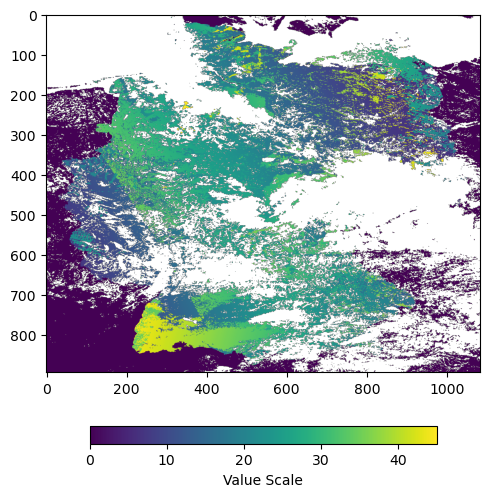

In [8]:
qq = vza_ds.GetRasterBand(9).ReadAsArray()
plotter(qq)

In [5]:
# calculate zenith and azimuth
file =  acq_time_list[2]
warped_ds = warp_raster_to_reference(file, reference_path=dem_path, output_path='MEM', resampling='near')
time_warp = warped_ds.GetRasterBand(doy).ReadAsArray()

lat = stackReader(lat_path)
lon = stackReader(lon_path)
dem = stackReader(dem_path)

# Flatten Unix time and convert to datetime
timestamps_flat = pd.to_datetime(time_warp.ravel(), unit='s', utc=True)

# Flatten lat/lon and DEM
lat_flat = lat.ravel()
lon_flat = lon.ravel()
dem_flat = dem.ravel()

solpos = solarposition.get_solarposition(time=timestamps_flat, latitude=lat_flat, longitude=lon_flat, altitude=dem_flat)

# Convert degrees to radians and reshape to original 2D
zenith_rad = np.deg2rad(solpos['zenith'].values).reshape(time_warp.shape)
azimuth_rad = np.deg2rad(solpos['azimuth'].values).reshape(time_warp.shape)

In [7]:
npTOdisk(zenith_rad, dem_path, '/data/Aldhani/eoagritwin/misc/for_Simon/sun_zenith_radians.tif', bandnames='July_9_2019', noData=-32768)
npTOdisk(azimuth_rad, dem_path, '/data/Aldhani/eoagritwin/misc/for_Simon/sun_azimuth_radians.tif', bandnames='July_9_2019', noData=-32768)

npTOdisk(solpos['zenith'].values.reshape(time_warp.shape), dem_path, '/data/Aldhani/eoagritwin/misc/for_Simon/sun_zenith_degrees.tif', bandnames='July_9_2019', noData=-32768)
npTOdisk(solpos['azimuth'].values.reshape(time_warp.shape), dem_path, '/data/Aldhani/eoagritwin/misc/for_Simon/sun_azimuth_degrees.tif', bandnames='July_9_2019', noData=-32768)